# Simple example of Bayesian decoder with AYA data

This tutorial makes heavy use of tools from Nelpy. See the [link](https://github.com/nelpy/nelpy) for documentation.

In [122]:
%reload_ext autoreload
%autoreload 2

## Import packages that we need

In [123]:
import numpy as np
import statistics
import matplotlib.pyplot as plt

import nelpy as nel
import nelpy.plotting as npl
from nelpy.plotting.core import imagesc

from ripple_heterogeneity.utils import functions, loading
import seaborn as sns

## Load data

In [124]:
# lets use this session
basepath = r"Z:\Data\GrosmarkAD\Achilles\Achilles_10252013"
# basepath = r"Z:\Data\HMC1\day8"
# load our spikes
st, cell_metrics = loading.load_spikes(
    basepath, putativeCellType="Pyr", brainRegion="CA1"
)

# load session epochs, these are to find linear track epoch
epoch_df = loading.load_epoch(basepath)

# load animal position
beh_df = loading.load_animal_behavior(basepath)


## format data into nelpy arrays

In [125]:
beh_epochs = nel.EpochArray([np.array([epoch_df.startTime, epoch_df.stopTime]).T])

# find linear track
idx = np.where(epoch_df.environment == "linear")[0]
beh_epochs_linear = beh_epochs[idx]

bad_idx = np.isnan(beh_df.x) | np.isnan(beh_df.y)
beh_df = beh_df[~bad_idx]

# straighten out track linear
x, y = functions.linearize_position(beh_df.x, beh_df.y)

# make position array
pos = nel.AnalogSignalArray(
    data=np.array(x),
    timestamps=beh_df.time,
    fs=1 / statistics.mode(np.diff(beh_df.time)),
)

# only include linear track
pos = pos[beh_epochs_linear]

# make min pos 0
pos.data = pos.data - np.nanmin(pos.data)


C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:420: UserWarning: creating support from abscissa_vals and sampling rate, fs!


## split linear track laps

You can see in the output that we have 42 outbound and 43 inbound laps

In [126]:
# get outbound and inbound epochs
(outbound_epochs, inbound_epochs) = functions.get_linear_track_lap_epochs(
    pos.abscissa_vals, pos.data[0], newLapThreshold=20
)
print(outbound_epochs)
print(inbound_epochs)


<EpochArray at 0x211a87deca0: 42 epochs> of length 17:33:359 minutes
<EpochArray at 0x211c86094f0: 43 epochs> of length 15:04:009 minutes


## Inspect laps

C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support


Text(0, 0.5, 'linearized position (cm)')

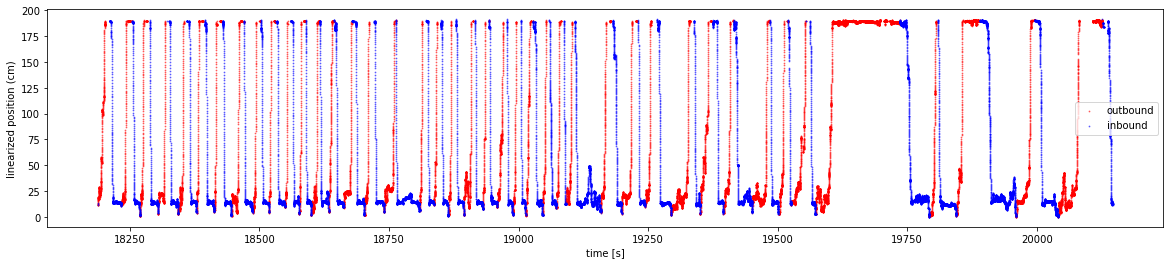

In [127]:
fig = plt.figure(figsize=(20, 4))
plt.scatter(
    pos[outbound_epochs].abscissa_vals,
    pos[outbound_epochs].data.T,
    color="red",
    marker=".",
    alpha=0.5,
    label="outbound",
    s=3,
)
plt.scatter(
    pos[inbound_epochs].abscissa_vals,
    pos[inbound_epochs].data.T,
    color="blue",
    marker=".",
    alpha=0.5,
    label="inbound",
    s=3,
)
plt.legend()

ax = plt.gca()
ax.set_xlabel("time [s]")
ax.set_ylabel("linearized position (cm)")


## Make tuning curves

We can make tuning curves separately for each direction, but here I'm simply making overall curves with both directions

In [128]:
def get_tuning_curves(
    pos, st_all, dir_epoch, speed_thres=4, ds=0.1, s_binsize=3, tuning_curve_sigma=3
):
    # compute and smooth speed
    speed1 = nel.utils.ddt_asa(pos[dir_epoch], smooth=True, sigma=0.1, norm=True)

    # find epochs where the animal ran > Xcm/sec
    run_epochs = nel.utils.get_run_epochs(speed1, v1=speed_thres, v2=speed_thres)

    # restrict spike trains to those epochs during which the animal was running
    st_run = st_all[dir_epoch][run_epochs]

    # smooth and re-bin:
    bst_run = st_run.bin(ds=ds)

    x_max = np.ceil(np.nanmax(pos[dir_epoch].data))
    x_min = np.floor(np.nanmin(pos[dir_epoch].data))

    n_bins = int((x_max - x_min) / s_binsize)

    tc = nel.TuningCurve1D(
        bst=bst_run,
        extern=pos[dir_epoch][run_epochs],
        n_extern=n_bins,
        extmin=x_min,
        extmax=x_max,
        sigma=tuning_curve_sigma,
        min_duration=0.1,
    )
    return tc, st_run, bst_run


# combine inbound outbound to single array
all_epochs = inbound_epochs | outbound_epochs

# call the above def to make tuning curves
tc, st_run, bst_run = get_tuning_curves(pos, st, outbound_epochs)


C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_eventarray.py:1765: UserWarning: interval duration is less than bin size: ignoring...
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nel

## Select place cells

Here, I look for cells with at least 100 spikes, at least 1hz peak rate, and at least a 1.5 peak to mean fr ratio

In [129]:
def restrict_to_place_cells(
    tc,
    st_run,
    bst_run,
    st_all,
    cell_metrics,
    place_cell_min_spks=100,
    place_cell_min_rate=1,
    place_cell_peak_mean_ratio=1.5,
):
    # locate pyr cells with >= 100 spikes, peak rate >= 1 Hz, peak/mean ratio >=1.5
    peak_firing_rates = tc.max(axis=1)
    mean_firing_rates = tc.mean(axis=1)
    ratio = peak_firing_rates / mean_firing_rates

    idx = (
        (st_run.n_events >= place_cell_min_spks)
        & (tc.ratemap.max(axis=1) >= place_cell_min_rate)
        & (ratio >= place_cell_peak_mean_ratio)
    )
    unit_ids_to_keep = (np.where(idx)[0] + 1).squeeze().tolist()

    sta_placecells = st_all._unit_subset(unit_ids_to_keep)
    tc = tc._unit_subset(unit_ids_to_keep)
    total_units = sta_placecells.n_active
    bst_run = bst_run.loc[:, unit_ids_to_keep]

    # restrict cell_metrics to place cells
    cell_metrics_ = cell_metrics[idx]

    return sta_placecells, tc, bst_run, cell_metrics_, total_units


(sta_placecells, tc, bst_run, cell_metrics_, total_units) = restrict_to_place_cells(
    tc, st_run, bst_run, st, cell_metrics, place_cell_peak_mean_ratio=1.5
)


## visualize place cells 

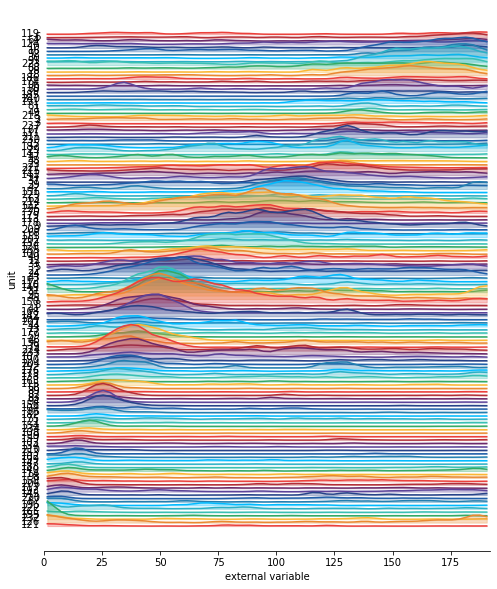

In [131]:
tc = tc.reorder_units()
npl.set_palette(npl.colors.rainbow)
with npl.FigureManager(show=True, figsize=(8, 10)) as (fig, ax):
    npl.utils.skip_if_no_output(fig)
    npl.plot_tuning_curves1D(tc, normalize=False, pad=3)


## Decode position using tuning curves and binned firing rate

Here the colormap is the posterior probability of the rat's position

The greenish color is the rats actual position

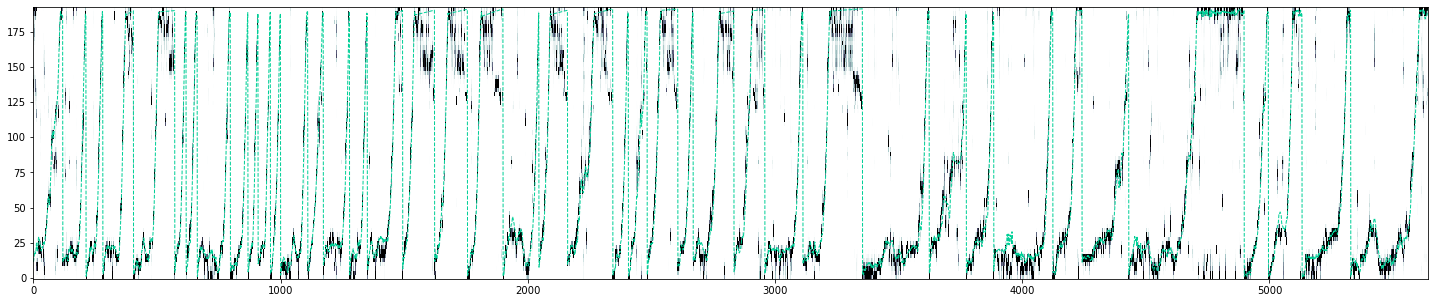

In [132]:
# this line runs the decoder
posteriors, lengths, mode_pth, mean_pth = nel.decoding.decode1D(
    bst_run, tc, xmin=np.nanmin(pos.data), xmax=np.nanmax(pos.data)
)

fig = plt.figure(figsize=(25, 5))
ax = plt.gca()
n_ext, n_bins = posteriors.shape
imagesc(
    x=np.arange(n_bins),
    y=np.arange(int(tc.bins[-1] + 1)),
    data=posteriors,
    cmap="bone_r",
    ax=ax,
    vmax=0.2,
)

plt.plot(pos(bst_run.bin_centers), "#00CF97", linewidth=1, linestyle="--")


### Let's zoom in

(0.0, 600.0)

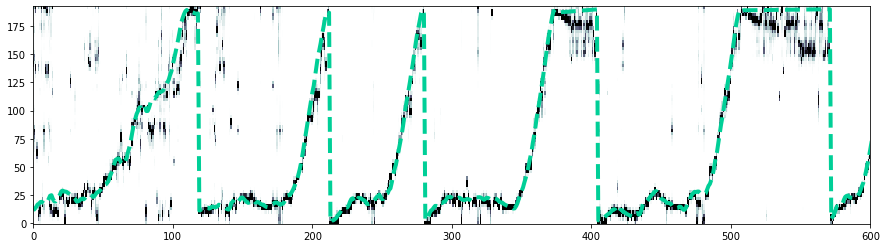

In [133]:
fig = plt.figure(figsize=(15, 4))
ax = plt.gca()
n_ext, n_bins = posteriors.shape
imagesc(
    x=np.arange(n_bins),
    y=np.arange(int(tc.bins[-1] + 1)),
    data=posteriors,
    cmap="bone_r",
    ax=ax,
    vmax=0.2,
)

plt.plot(pos(bst_run.bin_centers), "#00CF97", linewidth=4, linestyle="--")
plt.xlim(0, 600)


## We can compare actual vs. decoded all together

Text(0, 0.5, 'decoded')

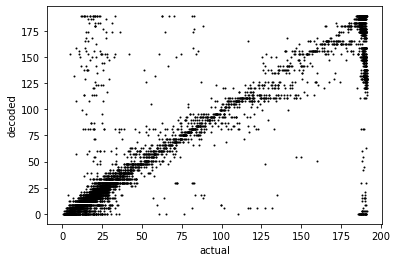

In [134]:
plt.scatter(pos(bst_run.bin_centers), mode_pth, color="k", s=1)
plt.xlabel("actual")
plt.ylabel("decoded")
